In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
%run functions.py

### Importação dos Dados

In [7]:
images = pd.read_csv("imageMNIST.csv", header=None, decimal=',')
labels = np.array(pd.read_csv("labelMNIST.csv", header=None))
X, zero_cols = zero_col(images)
y = np.asarray(labels)

### Treinamento

In [11]:
input_layer_size = X.shape[1]
hidden_layer_size = np.array([25])#Array com as camadas escondidas e suas respectivas quantidades de neurônios
num_labels = len(np.unique(y))
Lambda = 0.03
alpha = 0.8
nbr_iter = 800

theta, J_history = backpropagation(X, y, num_labels, hidden_layer_size, Lambda, alpha, nbr_iter, regularizada=True)

In [12]:
pred = prediction(X,theta)
print("Training Set Accuracy:",np.sum(pred == y)/len(y)*100,"%")

Training Set Accuracy: 94.17999999999999 %


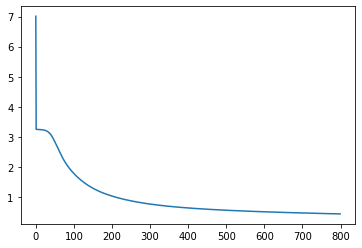

In [13]:
plt.plot(J_history)

## Visualização de $\Theta^{(1)}$

In [126]:
graf_theta = np.delete(theta[0], 0, axis=1)
for i in zero_cols:
    if i >= graf_theta.shape[1]:
        graf_theta = np.append(graf_theta, np.zeros(graf_theta.shape[0]).reshape([graf_theta.shape[0], 1]), axis=1)
    else:
        graf_theta = np.insert(graf_theta, i, np.zeros(graf_theta.shape[0]), axis=1)

# Normalizacao
minimo = np.min(graf_theta, axis=1)
maximo = np.max(graf_theta, axis=1)
for j in range(graf_theta.shape[1]):
    graf_theta[:,j] = (graf_theta[:,j] - minimo) / (maximo - minimo)

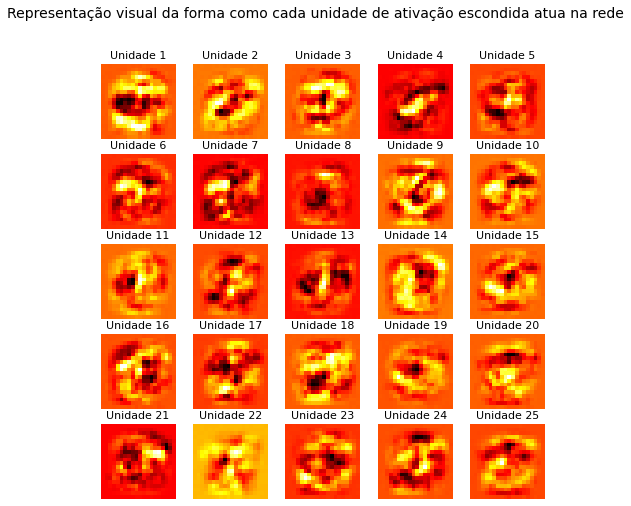

In [127]:
fig, axis = plt.subplots(5, 5,figsize=(8,8))
for i in range(5):
    for j in range(5):
        axis[i,j].imshow(graf_theta[5*i+j,:].reshape(20,20,order="F"),cmap='hot')
        axis[i,j].axis("off")
        axis[i,j].set_title('Unidade {}'.format(str(5*i+j+1)), fontsize=11)
fig.suptitle('Representação visual da forma como cada unidade de ativação escondida atua na rede', fontsize=14)
plt.show()